# Music generation with tensorflow

In [1]:
import tensorflow as tf
#!pip install mitdeeplearning
import mitdeeplearning as mdl

import numpy as np
import matplotlib.pyplot as plt
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

The system cannot find the path specified.


AssertionError: 

In [2]:
tf.__version__

'2.10.0'

In [8]:
songs = mdl.lab1.load_training_data()

example_song = songs[0]
print(example_song)

Found 817 songs in text
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


In [9]:
mdl.lab1.play_song(example_song)

In [5]:
songs_joined = "\n\n".join(songs)

vocab = sorted(set(songs_joined))

print("There are",len(vocab), "unique characters in the dataset")

There are 83 unique characters in the dataset


process the dataset for the learning task

vectorize the text

In [7]:
char2idx = {u:i for i, u in enumerate(vocab)}

idx2char = np.array(vocab)

In [10]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [11]:
#vectorize the songs string

def vectorize_string(string):
  vectorized = [char2idx[i] for i in string]
  return np.array(vectorized)

vectorized_songs = vectorize_string(songs_joined)

In [12]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

'X:1\nT:Alex' ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79]


In [13]:
#batch definition to create training examples

def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)

  input_batch = [vectorized_songs[i : i+seq_length] for i in idx]
  output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx]
  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])

  return x_batch, y_batch


# Perform some simple tests to make sure your batch function is working properly! 
test_args = (vectorized_songs, 10, 2)
if not mdl.lab1.test_batch_func_types(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_shapes(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_next_step(get_batch, test_args): 
   print("======\n[FAIL] could not pass tests")
else: 
   print("======\n[PASS] passed all tests!")

[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!


In [14]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 14 ('2')
  expected output: 31 ('F')
Step   1
  input: 31 ('F')
  expected output: 29 ('D')
Step   2
  input: 29 ('D')
  expected output: 1 (' ')
Step   3
  input: 1 (' ')
  expected output: 32 ('G')
Step   4
  input: 32 ('G')
  expected output: 30 ('E')


## The Recurrent Neural Network (RNN) model

In [15]:
#Define the RNN model

def LSTM(rnn_units):
  return tf.keras.layers.LSTM(
      rnn_units,
      return_sequences = True,
      recurrent_initializer = "glorot_uniform",
      recurrent_activation = "sigmoid",
      stateful = True,
  )

In [16]:
### Defining the RNN Model ###

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape = [batch_size, None]),
      LSTM(rnn_units),
      tf.keras.layers.Dense(vocab_size, activation="sigmoid")
  ])

  return model

model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

#### Test out the RNN model

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (32, None, 256)           21248     
                                                                 
 lstm (LSTM)                 (32, None, 1024)          5246976   
                                                                 
 dense (Dense)               (32, None, 83)            85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


In [18]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)


In [19]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([38, 55, 27, 40, 82, 54, 45, 72, 43, 36, 59, 77, 58, 37, 71, 12, 56,
        9, 77,  8,  7, 10, 72, 59, 70,  3, 68,  5, 36, 18, 19, 36, 39, 69,
       71,  9, 38, 82, 16, 14, 58, 10, 38, 51, 27, 32, 14, 59, 37, 51,  4,
       35,  6, 11, 51, 73, 35, 14, 59, 23, 66, 78, 38, 52, 81, 31, 50, 62,
       38, 25, 51, 15, 15, 37, 39, 16, 14, 62,  0, 15, 35, 29, 42, 67, 73,
       48, 41, 47, 73, 76, 31, 11, 74, 46, 12, 82, 65, 39, 69, 41],
      dtype=int64)

In [20]:
print("Input: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 'dc A2fg|agfa gfef|dcde f2|]!\n\nX:14\nT:Jockey to the Fair\nZ: id:dc-setdance-15\nM:6/8\nL:1/8\nK:G Major\nD'

Next Char Predictions: 
 'M_BO|^TqRKdvcLp0a-v,).qdo"m\'K67KNnp-M|42c.MZBG2dLZ#J(/ZrJ2d<kwM[zFYgM>Z33LN42g\n3JDQlrWPVruF/sU0|jNnP'


#### Training the model: loss and training operations

In [21]:
## Define the loss function
# we will use sparse_categorical_crossentropy loss.

def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss

example_batch_loss = compute_loss(y, pred)

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 83)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.4200153


c:\Users\nabaw\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


In [22]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 5000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

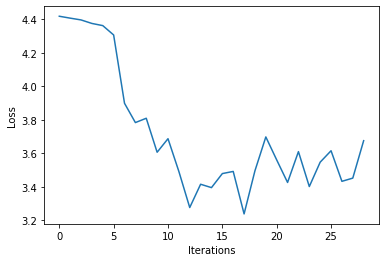

  1%|          | 29/5000 [00:52<2:31:23,  1.83s/it]


KeyboardInterrupt: 

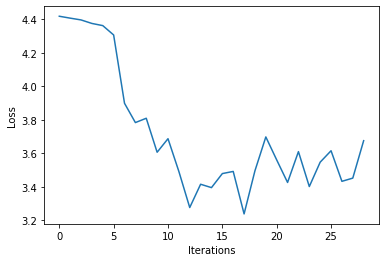

In [23]:
### Define optimizer and training operation ###

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)

optimizer = tf.optimizers.Adagrad()

@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    y_hat = model(x)
    loss = compute_loss(y, y_hat)

  grads = tape.gradient(loss, model.trainable_variables)

  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  return loss


##################
# Begin training!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

In [ ]:
'''TODO: Rebuild the model using a batch_size=1'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

In [ ]:
### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  '''TODO: convert the start string to numbers (vectorize)'''
  input_eval = [char2idx[i] for i in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      '''TODO: evaluate the inputs and generate the next character predictions'''
      predictions = model(input_eval)
      
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      '''TODO: use a multinomial distribution to sample'''
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      
      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      '''TODO: add the predicted character to the generated text!'''
      # Hint: consider what format the prediction is in vs. the output
      text_generated.append(idx2char[predicted_id])
    
  return (start_string + ''.join(text_generated))



In [ ]:
'''TODO: Use the model and the function defined above to generate ABC format text of length 1000!
    As you may notice, ABC files start with "X" - this may be a good start string.'''
generated_text = generate_text(model, start_string="X", generation_length=1000) # TODO
# generated_text = generate_text('''TODO''', start_string="X", generation_length=1000)

In [ ]:
### Play back generated songs ###

generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs): 
  # Synthesize the waveform from a song
  waveform = mdl.lab1.play_song(song)

  # If its a valid song (correct syntax), lets play it! 
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)